In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# La conception de filtres actifs à temps continu

## Introduction

### Survol

Ce document constitue une introduction à la conception de filtres analogiques. On considérera plus particulièrement les filtres actifs, i.e. comprenant au moins un élément actif comme un amplificateur opérationnel. Le but du document est de présenter les différentes étapes de conception d’un filtre, de la spécification à la réalisation en circuits. Un filtre analogique actif est un circuit électrique, formé typiquement de résistances, de condensateurs et d’un ou plusieurs amplificateurs opérationnels, qui modifie de manière continue, linéaire et stationnaire un signal électrique d’entrée pour produire un signal électrique de sortie ayant des caractéristiques désirées. On peut classifier les filtres en cinq grandes classes :

- les filtres passe-bas
- les filtres passe-haut
- les filtres passe-bande
- les filtres coupe-bande
- les filtres passe-tout


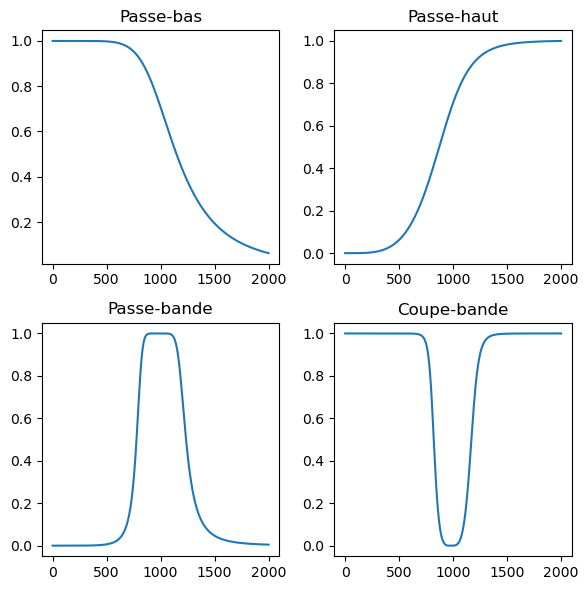

In [21]:
a1, b1 = signal.butter(4, 1000, btype='low', analog=True)
a2, b2 = signal.butter(4, 1000, btype='high', analog=True)
a3, b3 = signal.butter(4, [800, 1200], btype='bandpass', analog=True)
a4, b4 = signal.butter(4, [800, 1200], btype='bandstop', analog=True)

w = np.linspace(0,2000,2000)

w1,h1 = signal.freqs(a1,b1,w)
w2,h2 = signal.freqs(a2,b2,w)
w3,h3 = signal.freqs(a3,b3,w)
w4,h4 = signal.freqs(a4,b4,w)

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)

ax1 = plt.subplot(2,2,1)
ax1.plot(w1, np.abs(h1))
ax1.set_title("Passe-bas")

ax2 = plt.subplot(2,2,2)
ax2.plot(w2, np.abs(h2))
ax2.set_title("Passe-haut")

ax3 = plt.subplot(2,2,3)
ax3.plot(w3, np.abs(h3))
ax3.set_title("Passe-bande")

ax4 = plt.subplot(2,2,4)
ax4.plot(w4, np.abs(h4))
ax4.set_title("Coupe-bande")
plt.tight_layout()

Dans ce document, on étudiera uniquement les quatre premières classes de filtres. Ces filtres se définissent surtout par les fréquences qu’ils laissent passer et les fréquences qu’ils coupent ou atténuent. La figure précédente illustre de quelle façon chacun de ces 4 types de filtres affecte l’amplitude d’un signal en fonction de sa fréquence. L’échelle des fréquences est en radians par seconde. Quant aux filtres passe-tout, ils n’affectent que la phase d’un signal pas son amplitude. 

Chacun de ces types de filtres présente une fonction de transfert ayant des caractéristiques propres. Pour les filtres d’ordre supérieur (c’est-à-dire d’ordre supérieur à $N=2$), on peut toujours ramener la fonction de transfert globale à un produit de sous-fonctions d’ordre 2, et éventuellement d’une fonction d’ordre 1 pour les ordres impairs. Autrement dit, un filtre d’ordre élevé peut toujours être réalisé comme une cascade de filtres d’ordre 2 et éventuellement d’un filtre d’ordre 1 pour les ordres impairs. De plus, on verra que chacun de ces types de filtres (passe-bas, passe-haut, passebande et coupe-bande) peut être obtenu en appliquant une transformation à la variable s dans la fonction de transfert d’un filtre passe-bas normalisé, i.e. dont la bande passante va de 0 à 1 radian par seconde. Il est donc important de bien maîtriser l’analyse et la conception des filtres passe-bas, puisque ceux-ci pourront ensuite être facilement transformés pour donner le
filtre désiré.

Les connaissances antérieures sur lesquelles se basent ce document sur la conception de filtres analogiques sont, notamment :
- les fonctions de transfert $H(s)$ d’ordre 2 ;
- la décomposition d’un polynôme d’ordre $N$ en sous-facteurs d’ordre 1 ou 2 selon les racines obtenues ;
- les notions de facteur de qualité $Q$, gain $K$ et fréquence centrale $f_0$ d’un filtre passe-bande d’ordre 2 ;
- les circuits actifs réalisant un filtre d’ordre 2 (configuration MFB).

## Éléments de conception d’un filtre analogique

La conception d’un filtre analogique se fait en général selon les étapes suivantes :

1) **Détermination des spécifications du filtre à concevoir**, en particulier les tolérances de gain dans la bande passante, dans la bande atténuée et pour la bande de transition, de même que les tolérances de phase s’il y a lieu.

2) **Transformations des spécifications du filtre** à concevoir en spécifications du filtre passe-bas normalisé correspondant.

3) **Choix d’un filtre passe-bas normalisé** (ex. : Butterworth, Chebyshev, Bessel, etc.) et de l’ordre $N$ minimal requis pour répondre aux spécifications. On obtient alors sa fonction de transfert $H(s)$ par des tables ou encore par des outils de conception comme la librairie *scipy* de Python.

4) **Transformation et dénormalisation du filtre passe-bas normalisé**, en appliquant les transformations fréquentielles nécessaires sur la variable $s$ dans sa fonction de transfert. On obtient alors la fonction de transfert globale du filtre à réaliser, que l’on décompose en sous-fonctions d’ordre 2 qui seront mises en oeuvre en circuits.

5) **Synthèse du circuit analogique** (actif), en choisissant une structure de filtre et des valeurs standards de composants, permettant de réaliser la fonction de transfert produite à l’étape 4.

6) **Vérification du circuit réalisé**, mesure des performances afin de valider que le filtre rencontre les spécifications fixées à l’étape 1. Réglages finaux si nécessaires.

## Organisation du document

Le reste de ce document couvrira l’essentiel des bases nécessaires à mettre en oeuvre cette démarche de conception. Au chapitre 1, on présentera les approximations les plus importantes du passe-bas idéal (filtres de Butterworth, de Chebyshev et de Bessel) avec leurs caractéristiques. Au chapitre 2, on montrera comment appliquer des transformations
fréquentielles à la fonction de transfert d’un filtre passe-bas normalisé pour obtenir rapidement la fonction de transfert d’autres types de filtres (passehaut, passe-bande, etc.). Au chapitre 3, on présentera la procédure pour choisir une fonction de transfert normalisée, notamment son ordre, selon les contraintes du filtre à réaliser. Le chapitre 3 couvre également la décomposition de fonctions de transfert d’ordre N en sous-fonctions d’ordre 2. Finalement, le chapitre 4 présentera les structures de filtres actifs d’ordre
2 qui permettent de mettre en oeuvre les fonctions de transfert à réaliser.